# Convolution base model (from input to last convolutional layer)

Our device can only accelerate models that are in int8. 
But gradCam likely requires saving our model in float.

To get over this problem, we can use 2 models, one that does the convolutional operation (accelarated), and one that does the classification and GradCam (not accelarated).

Here I am taking the convolutional layers of a ResNet50 as an example of a the convolutional network.

In [2]:
import tensorflow as tf
print(tf.__version__)
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

2024-04-15 11:01:30.025458: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 11:01:30.025723: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 11:01:30.027948: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 11:01:30.054792: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 11:01:30.508420: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

2.16.1


We use a small dataset that can be used to quantize the convolutional network.

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
print(PATH)

/home/kevin/.keras/datasets/cats_and_dogs_filtered


In [4]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


2024-04-15 11:01:32.709141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


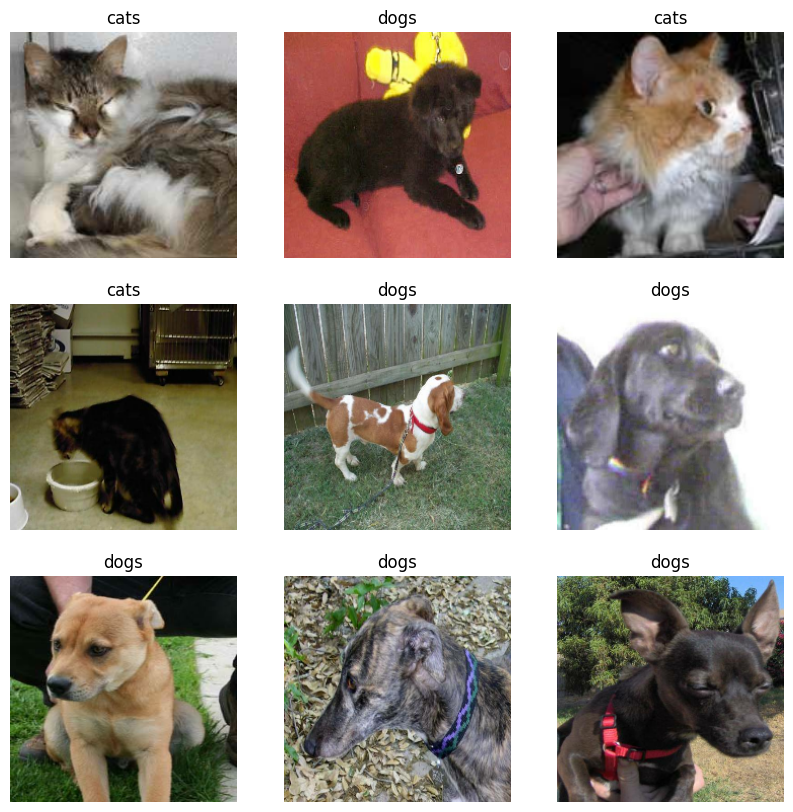

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
print("Number of batches in validation set:", val_batches)
print(val_batches // 5)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

Number of batches in validation set: tf.Tensor(32, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)


<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
(32, 224, 224, 3) (32,)


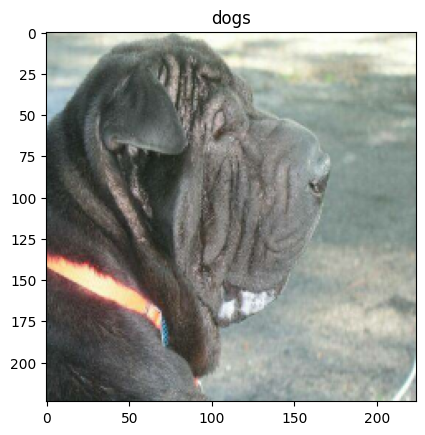

(array([3.0000e+00, 1.2200e+02, 1.3150e+03, 4.2370e+03, 6.4600e+03,
        6.7920e+03, 6.5530e+03, 6.0900e+03, 5.3740e+03, 4.9290e+03,
        4.6310e+03, 4.7430e+03, 5.2800e+03, 6.4970e+03, 8.6270e+03,
        9.7200e+03, 1.0617e+04, 9.0230e+03, 8.9190e+03, 9.2380e+03,
        8.3460e+03, 5.6520e+03, 3.3910e+03, 2.2840e+03, 1.9050e+03,
        1.7140e+03, 1.5200e+03, 1.8430e+03, 1.9640e+03, 2.7390e+03]),
 array([ 15.04488659,  23.04339027,  31.04189491,  39.04039764,
         47.03890228,  55.03740692,  63.03590775,  71.0344162 ,
         79.03291321,  87.03141785,  95.02992249, 103.02842712,
        111.02693176, 119.0254364 , 127.02394104, 135.02244568,
        143.02095032, 151.01945496, 159.01795959, 167.01646423,
        175.01496887, 183.01347351, 191.01196289, 199.01046753,
        207.00897217, 215.00747681, 223.00598145, 231.00448608,
        239.00299072, 247.00149536, 255.        ]),
 <BarContainer object of 30 artists>)

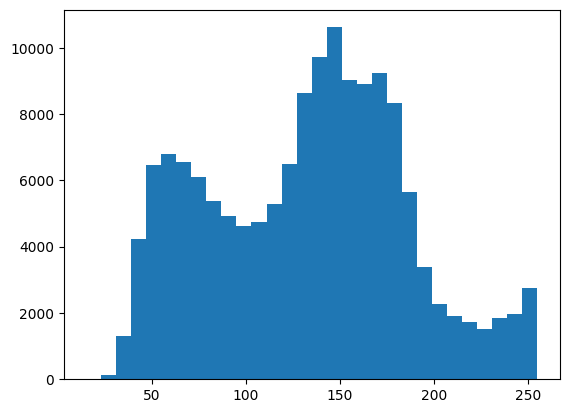

In [7]:
# get one image from the training dataset
images, labels = next(iter(train_dataset))
print(type(images))
# get the datatype of the image
print(images.dtype)
print(images.shape, labels.shape)
image = images[0].numpy().astype("uint8").copy()
plt.imshow(image)
plt.title(class_names[labels[0]])
plt.show()

plt.hist(images[0].numpy().flatten(), bins=30)


In [8]:
%run imagenet1000_clsidx_to_labels.py

In [9]:
imagenet_labels[0]

'tench, Tinca tinca'

## Create our model


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import (
    ResNet50,
    preprocess_input,
    decode_predictions,
)

In [11]:
model = ResNet50()

(224, 224, 3) (32,)


Text(0.5, 1.0, 'cats')

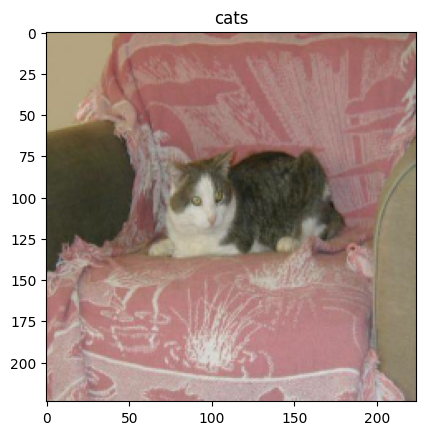

In [122]:
# get one image from the training dataset
images, labels = next(iter(train_dataset))
print(image.shape, labels.shape)
image = images[0].numpy().astype("uint8").copy()
plt.imshow(image)
plt.title(class_names[labels[0]],)

In [13]:
# Function to print the 5 best results from the model output 
def print_best_results(res):
  for i in range(5):
    maxIndex = np.argmax(res)
    print(imagenet_labels[maxIndex], res[0,maxIndex])
    res[0,maxIndex] = 0  

In [14]:
res = model(image[np.newaxis, ...])
print_best_results(res.numpy())

window screen 0.38714042
tabby, tabby cat 0.18268149
lynx, catamount 0.15767498
tiger cat 0.073768415
Persian cat 0.061376665


We will save the entire ResNet50 so that we can use it for TF Lite inference.

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp1h994vj0/assets


INFO:tensorflow:Assets written to: /tmp/tmp1h994vj0/assets


: 

In [18]:
# Save the model.
with open('resnet50_model.tflite', 'wb') as f:
  f.write(tflite_model)

NameError: name 'tflite_model' is not defined

We can also optimize our model with the default parameters. This quantiize all fixed parameters.

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp5ss6pqro/assets


INFO:tensorflow:Assets written to: /tmp/tmp5ss6pqro/assets
2024-04-15 10:10:05.198577: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-04-15 10:10:05.198599: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-04-15 10:10:05.198751: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5ss6pqro
2024-04-15 10:10:05.235829: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-04-15 10:10:05.235857: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5ss6pqro
2024-04-15 10:10:05.340996: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2024-04-15 10:10:05.809529: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5ss6pqro
2024-04-15 10:10:05.950710: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [ ]:
# Save the model.
with open('resnet50_model_optim_default.tflite', 'wb') as f:
  f.write(tflite_model)

Save imagenet labels for our c++ program.

In [58]:
# save the imagenet labels to a text file, one label per line
with open('imagenet_labels.txt', 'w') as f:
  for k in imagenet_labels:
    f.write(imagenet_labels[k] + '\n')

### Compare TF and TFLite models

We use an image from a file so that we can do the same in c++

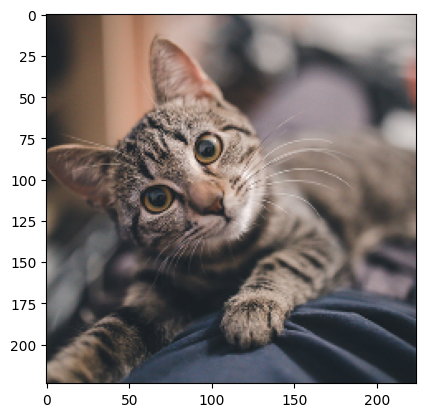

In [111]:
# load image from file with openCV
image = cv2.imread('../data/cat.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
plt.imshow(image)

In [17]:
# load the tenforflow lite model from a file
interpreter = tf.lite.Interpreter(model_path='resnet50_model.tflite')

In [19]:
# run inference with the TFLite model
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

# run inference
input_shape = input_details[0]['shape']
input_data = image[np.newaxis, ...].astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print_best_results(output_data)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 186, 'shape': array([   1, 1000], dtype=int32), 'shape_signature': array([  -1, 1000], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
tabby, tabby cat 0.26540387
lynx, catamount 0.25243634
tiger cat 0.20394138
Egyptian cat 0.14051804
snow leopard, ounce, Panthera uncia 0.011604675


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [20]:
res = model(image[np.newaxis, ...])
# get the top result
print_best_results(res.numpy())

tabby, tabby cat 0.26540637
lynx, catamount 0.2524339
tiger cat 0.20394234
Egyptian cat 0.14051737
snow leopard, ounce, Panthera uncia 0.011604646


To run similar inference with the c++ program

```
cd ~/repo/tfl_inference_classification/build
./inference_classification ../python/resnet50_model_optim_default.tflite ../data/cat.jpg  -l ../python/imagenet_labels.txt 
```

If you get the same results, we know that the c++ program works as expected.

## Base convolutional model

We want to get rid of the classifier head of the resnet50. The model will go from input to the last convolutional layer.

## 

In [67]:
# print the name of the layers
for i, layer in enumerate(model.layers):
    if i <  10 or i > 160: 
        print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
161 conv5_block2_3_conv
162 conv5_block2_3_bn
163 conv5_block2_add
164 conv5_block2_out
165 conv5_block3_1_conv
166 conv5_block3_1_bn
167 conv5_block3_1_relu
168 conv5_block3_2_conv
169 conv5_block3_2_bn
170 conv5_block3_2_relu
171 conv5_block3_3_conv
172 conv5_block3_3_bn
173 conv5_block3_add
174 conv5_block3_out
175 avg_pool
176 predictions


We want conv5_block3 as our new output.

In [68]:
last_conv_layer = model.get_layer("conv5_block3_out") # last convolutional layer
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

In [69]:
# print the name of the layers
for i, layer in enumerate(last_conv_layer_model.layers):
    if i <  10 or i > 160: 
        print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
161 conv5_block2_3_conv
162 conv5_block2_3_bn
163 conv5_block2_add
164 conv5_block2_out
165 conv5_block3_1_conv
166 conv5_block3_1_bn
167 conv5_block3_1_relu
168 conv5_block3_2_conv
169 conv5_block3_2_bn
170 conv5_block3_2_relu
171 conv5_block3_3_conv
172 conv5_block3_3_bn
173 conv5_block3_add
174 conv5_block3_out


In [123]:
res = last_conv_layer_model(image[np.newaxis, ...])
res.shape

TensorShape([1, 7, 7, 2048])

* The output is a set of 2048 features extracted from the convolutional layers. 
* There is still some spatial information, but the resolution is 7x7 instead of 224x224.
* This is 5 time downsampling by a factor of 2.


In [76]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(last_conv_layer_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpw0cnmudo/assets


INFO:tensorflow:Assets written to: /tmp/tmpw0cnmudo/assets
2024-04-15 11:28:09.953544: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-04-15 11:28:09.953574: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-04-15 11:28:09.953727: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpw0cnmudo
2024-04-15 11:28:09.981830: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-04-15 11:28:09.981855: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpw0cnmudo
2024-04-15 11:28:10.087316: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2024-04-15 11:28:10.561059: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpw0cnmudo
2024-04-15 11:28:10.701764: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [77]:
# Save the model.
with open('resnet50_conv_base_model_optim_default.tflite', 'wb') as f:
  f.write(tflite_model)

In [124]:
# load the tenforflow lite model from a file
interpreter = tf.lite.Interpreter(model_path='resnet50_conv_base_model_optim_default.tflite')

In [125]:
# run inference with the TFLite model
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

# run inference
input_shape = input_details[0]['shape']
input_data = image[np.newaxis, ...].astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])


[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 180, 'shape': array([   1,    7,    7, 2048], dtype=int32), 'shape_signature': array([  -1,    7,    7, 2048], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [126]:
output_data.shape

(1, 7, 7, 2048)

In [127]:
# max value in output_data
print("max:" , output_data.max())
# index of max value
print("index of max: " , np.argmax(output_data))

max: 41.465942
index of max:  52893


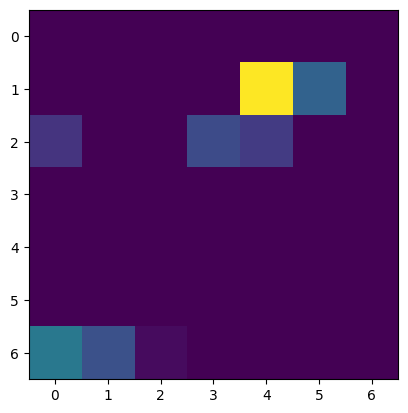

In [128]:
plt.imshow(output_data[0,:,:,0])

You can test that we get the same results in a C++ program using the same model and image.

```
./inference_base_conv ../python/resnet50_conv_base_model_optim_default.tflite ../data/cat.jpg
```

You should get the same index for the peak value.

## Classifier head 

We can build a classier head for the ResNet50 model.

In [129]:
# print the name of the layers
for i, layer in enumerate(model.layers):
    if i > 170: 
        print(i, layer.name)

171 conv5_block3_3_conv
172 conv5_block3_3_bn
173 conv5_block3_add
174 conv5_block3_out
175 avg_pool
176 predictions


In [130]:
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ["avg_pool", "predictions"]: # 175, 176 layers in ResNet50
    x = model.get_layer(layer_name)(x)

classifier_model = tf.keras.Model(classifier_input, x)

In [131]:
classifier_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 7, 7, 2048)]      0         
                                                                 
 avg_pool (GlobalAveragePool  (None, 2048)             0         
 ing2D)                                                          
                                                                 
 predictions (Dense)         (None, 1000)              2049000   
                                                                 
Total params: 2,049,000
Trainable params: 2,049,000
Non-trainable params: 0
_________________________________________________________________


In [132]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(classifier_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpkmkn61ra/assets


INFO:tensorflow:Assets written to: /tmp/tmpkmkn61ra/assets
2024-04-15 15:33:42.433240: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-04-15 15:33:42.433261: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-04-15 15:33:42.433380: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkmkn61ra
2024-04-15 15:33:42.434205: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-04-15 15:33:42.434221: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkmkn61ra
2024-04-15 15:33:42.435973: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2024-04-15 15:33:42.447875: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkmkn61ra
2024-04-15 15:33:42.452561: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

# Save the model.
with open('resnet50_classifier_model_optim_default.tflite', 'wb') as f:
  f.write(tflite_model)

In [133]:
# load the tenforflow lite model from a file
interpreter = tf.lite.Interpreter(model_path='resnet50_classifier_model_optim_default.tflite')


We can feed the output of the convolutional network into the input of the classifier head in order to do the classification task.

In [134]:
# run inference with the TFLite model
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)


[{'name': 'serving_default_input_3:0', 'index': 0, 'shape': array([   1,    7,    7, 2048], dtype=int32), 'shape_signature': array([  -1,    7,    7, 2048], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 6, 'shape': array([   1, 1000], dtype=int32), 'shape_signature': array([  -1, 1000], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [135]:
output_data.shape

(1, 7, 7, 2048)

In [136]:

# run inference
input_shape = input_details[0]['shape']
input_data = output_data
interpreter.set_tensor(input_details[0]['index'], output_data)
interpreter.invoke()
results = interpreter.get_tensor(output_details[0]['index'])
print_best_results(results)


tabby, tabby cat 0.32573673
tiger cat 0.27013612
Egyptian cat 0.031631418
Siberian husky 0.028686516
malamute, malemute, Alaskan malamute 0.023662563


## GradCam with the classifier head

We can modify the classifier head in order to GradCam with it.

In [137]:
class GradCamHeadModel(tf.Module):
  # all functions in there should be tensor flow functions
  def __init__(self, model):
    self.classifier_model = model # model should be the head of ResNet50
    

# The inference function
  @tf.function(input_signature=[tf.TensorSpec([None, 7, 7, 2048], tf.float32)])
  def infer(self, x):
    return self.classifier_model(x)

# Forward to last convolutional layer
  @tf.function(input_signature=[tf.TensorSpec([None, 7, 7, 2048], tf.float32)])
  def infer_grad_cam(self, x):
    with tf.GradientTape() as tape:
      tape.watch(x)
      preds = self.classifier_model(x)
      top_pred_index = tf.argmax(preds[0])
      top_class_channel = preds[:, top_pred_index]
    
    
    grads = tape.gradient(top_class_channel, x)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    x = tf.squeeze(x)
    x = x*pooled_grads[tf.newaxis,tf.newaxis,:] # broadcasting
    gradcam = tf.reduce_mean(x, axis=-1)
    gradcam = tf.nn.relu(gradcam)/tf.reduce_max(gradcam)
    return {"preds":preds,
            "gradcam":gradcam,  
            "top_pred_index":top_pred_index,
            "top_class_channel":top_class_channel}
    

In [138]:
gradCam_model = GradCamHeadModel(classifier_model)

In [139]:
gcRes = gradCam_model.infer_grad_cam(output_data)
gcRes

{'gradcam': <tf.Tensor: shape=(7, 7), dtype=float32, numpy=
 array([[3.1813901e-02, 3.2783557e-02, 1.3789801e-02, 0.0000000e+00,
         0.0000000e+00, 3.0750202e-03, 0.0000000e+00],
        [5.3622995e-02, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 8.2508624e-03, 0.0000000e+00],
        [2.8129542e-04, 0.0000000e+00, 0.0000000e+00, 2.5589457e-01,
         4.3442193e-01, 2.7419078e-01, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 3.7483424e-01, 1.0000000e+00,
         9.5287526e-01, 5.6313026e-01, 1.5042099e-02],
        [3.8262244e-02, 0.0000000e+00, 9.9660799e-02, 5.3619123e-01,
         7.7075547e-01, 3.4272826e-01, 0.0000000e+00],
        [2.3702672e-02, 8.6624017e-03, 0.0000000e+00, 0.0000000e+00,
         3.6787845e-02, 0.0000000e+00, 0.0000000e+00],
        [5.3374421e-02, 9.1153577e-02, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]], dtype=float32)>,
 'preds': <tf.Tensor: shape=(1, 1000), dtype=float32, 

In [140]:
gradcam = gcRes["gradcam"].numpy()
gradcam = cv2.resize(gradcam, (224, 224))
gradcam.shape

(224, 224)

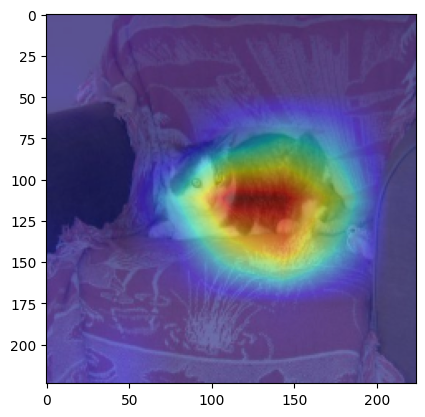

In [141]:
plt.imshow(image)
plt.imshow(gradcam, alpha=0.5, cmap='jet')

In [144]:
SAVED_MODEL_DIR = "gradcam_resnet50_head_model"
tf.saved_model.save(
    gradCam_model,
    SAVED_MODEL_DIR,
    signatures={
        'infer_grad_cam':
            gradCam_model.infer_grad_cam.get_concrete_function(),
        'infer':
            gradCam_model.infer.get_concrete_function(),
    })

INFO:tensorflow:Assets written to: gradcam_resnet50_head_model/assets


INFO:tensorflow:Assets written to: gradcam_resnet50_head_model/assets


In [146]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

2024-04-15 15:39:37.458856: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-04-15 15:39:37.458881: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-04-15 15:39:37.459009: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: gradcam_resnet50_head_model
2024-04-15 15:39:37.460047: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-04-15 15:39:37.460071: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: gradcam_resnet50_head_model
2024-04-15 15:39:37.464089: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2024-04-15 15:39:37.481416: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: gradcam_resnet50_head_model
2024-04-15 15:39:37.488792: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; 

In [147]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite delegate for select TF ops.
2024-04-15 15:39:59.117149: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-15 15:39:59.117733: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
INFO: TfLiteFlexDelegate delegate: 0 nodes delegated out of 3 nodes with 0 partitions.



In [148]:
signatures = interpreter.get_signature_list()
print(signatures)

{'infer': {'inputs': ['x'], 'outputs': ['output_0']}, 'infer_grad_cam': {'inputs': ['x'], 'outputs': ['gradcam', 'preds', 'top_class_channel', 'top_pred_index']}}


In [153]:
preds = gradCam_model.infer(x=output_data)
prediction = tf.argmax(preds[0])
print(imagenet_labels[prediction.numpy()])

tabby, tabby cat


In [160]:
infer = interpreter.get_signature_runner("infer")
preds_tfl = infer(x=output_data)
print(imagenet_labels[tf.argmax(preds_tfl["output_0"][0]).numpy()])

tabby, tabby cat


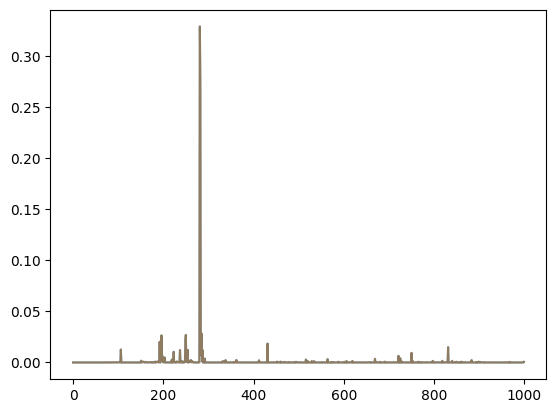

In [162]:
plt.plot(preds[0].numpy())
plt.plot(preds_tfl["output_0"][0],alpha=0.5)

In [168]:
infer_grad_cam = interpreter.get_signature_runner("infer_grad_cam")
preds_tfl = infer_grad_cam(x=output_data)

In [169]:
preds_tfl

{'gradcam': array([[3.1813826e-02, 3.2783497e-02, 1.3789735e-02, 0.0000000e+00,
         0.0000000e+00, 3.0749738e-03, 0.0000000e+00],
        [5.3622931e-02, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 8.2508344e-03, 0.0000000e+00],
        [2.8138078e-04, 0.0000000e+00, 0.0000000e+00, 2.5589481e-01,
         4.3442205e-01, 2.7419069e-01, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 3.7483448e-01, 1.0000000e+00,
         9.5287555e-01, 5.6313014e-01, 1.5042132e-02],
        [3.8262203e-02, 0.0000000e+00, 9.9661022e-02, 5.3619146e-01,
         7.7075523e-01, 3.4272796e-01, 0.0000000e+00],
        [2.3702558e-02, 8.6623989e-03, 0.0000000e+00, 0.0000000e+00,
         3.6787860e-02, 0.0000000e+00, 0.0000000e+00],
        [5.3374324e-02, 9.1153443e-02, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]], dtype=float32),
 'preds': array([[4.88442311e-07, 2.31178069e-06, 8.55188489e-07, 9.05678098e-06,
         2.38513258e-0

In [177]:
gradcam_tfl = preds_tfl["gradcam"]
print("maximal value in the gradcam tensor:", gradcam_tfl.max())
print("index of maximal value in the gradcam tensor:", np.argmax(gradcam_tfl))
gradcam_tfl = cv2.resize(gradcam_tfl, (224, 224))

maximal value in the gradcam tensor: 1.0
index of maximal value in the gradcam tensor: 24


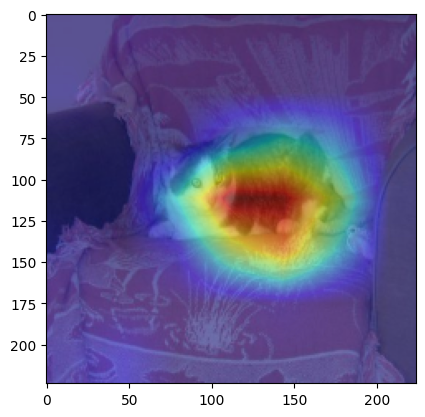

In [174]:
plt.imshow(image)
plt.imshow(gradcam_tfl, alpha=0.5, cmap='jet')